# chapter 7 : 앙상블 학습과 랜덤 포레스트

- 일련의 예측기(즉, 분류나 회귀 모델)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있다
- 일련의 예측기를 앙상블이라고 부른다
- 이를 앙상블 학습이라고 하며, 앙상블 학습 알고리즘을 앙상블 방법이라고 한다
- 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킬 수 있다
- 예측을 하려면 모든 개별 트리의 예측을 구하면 된다
- 가장 많은 선택을 받은 클래스를 예측으로 삼는다
- 결정 트리의 앙상블을 랜덤 포레스트라고 한다
- 7장에서는 배깅, 부스팅, 스태킹, 랜덤포레스트 를 다룬다

### setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

### 7.1 투표 기반 분류기

- 정확도가 80%인 분류기 여러 개를 훈련시켰다고 가정하자
- 아마도 로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, K-최근접 이웃 분류기 등을 가지고 있을 것이다
- 더 좋은 분류기를 만드는 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것이다
- 이렇게 다수결 투표로 정해지는 분류기를 직접 투표(hard voting) 분류기 라고 한다

In [2]:
#동전을 던졌을 때, 앞면이 51%인 동전이 있다고 가정하자

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

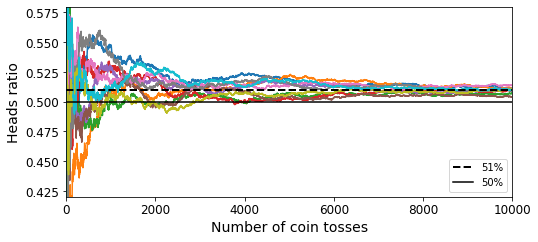

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

- 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축한다고 가정하자
- 가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대할 수 있다(큰 수의 법칙)
- 하지만 이런 가정은 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 가능하다
- 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘한다

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
# 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier)를 만들고 훈련시키는 코드
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver = 'liblinear')
rnd_clf = RandomForestClassifier(n_estimators=10)
svm_clf = SVC(gamma = 'auto')

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='g...
                                        

In [7]:
# 각 분류기의 테스트셋 정확도

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.888
VotingClassifier 0.904


- 원래 같으면 투표기반 분류기가 다른 개별 분류기 보다 성능이 좋아야 하는데 이건 좀 이상하게 나왔다 
- 모든 분류기가 클래스의 확률을 예측할 수 있으면(즉, predict_proba() 메서드가 있으면), 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있다
- 이를 간접 투표라고 한다
- 이 방식은 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높다
- 이 방식을 사용하기 위해서는 voting = "hard"를 voting="soft"로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 된다
- SVC는 기본값에서는 클래스 확률을 ㅈ공하지 않으므로 probability 매개변수를 True로 지정해야 한다
- 밑의 코드는 앞의 코드를 간접 투표 방식으로 사용하도록 변경해보았다

In [8]:
log_clf = LogisticRegression(solver = 'liblinear')
rnd_clf = RandomForestClassifier(n_estimators=10)
svm_clf = SVC(gamma = 'auto', probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='g...
                                        

In [9]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.912
SVC 0.888
VotingClassifier 0.92


- 예상대로 정확도가 올라갔고 투표 기반 분류기가 성능이 높아졌다

### 7.2 배깅과 페이스팅

- 다양한 분류기를 만드는 한 가지 방법은 각기 다른 훈련 알고리즘을 사용하는 것이다
- 또 다른 방법은 같은 알고리즘을 사용하지만 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습 시키는 것이다
- 훈련 세트에서 중복을 허용하여 샘플링하는 방식을 배깅(bagging)(bootstrap aggregating의 줄임말)이라 한다
- 훈련 세트에서 중복을 허용하지 않고 샘플링 하는 방식을 페이스팅(pasting)이라고 한다
- 다시 말해 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있다
- 하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있다
- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다
- 수집 함수는 전형적으로 분류일 때는 통계적 최빈값이고 회귀에 대해서는 평균을 계산한다

### 7.2.1 사이킷런의 배깅과 페이스팅

- 사이킷런은 배깅과 페이스팅을 위해 간편한 API로 구성된 BaggingClassifier(회귀의 경우에는 BaggingRegressor)를 제공한다
- 다음은 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드이다
- 각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련된다
- 페이스팅을 사용하려면 bootstrap = False로 지정하면 된다
- n_jobs 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정한다
- -1로 지정하면 가용한 모든 코어를 사용

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.912


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

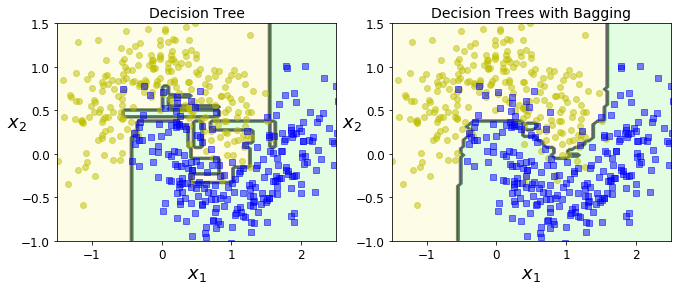

In [14]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

- 단일 결정 트리와 500개 트리로 만든 배깅 앙상블 비교
- 부스트트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다
- 하지만 이는 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다
- 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호한다
- 시간과 CPU파워에 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 더 나은쪽을 선택하는 것이 좋다

### 7.2.2 oob 평가 (Out-of-Bag evaluation)

- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있다
- BaggingClassifier는 기본값으로 중복을 허용하여 훈련 세트의 크기 만큼인 m개의 샘플을 선택한다
- 이는 평균적으로 각 예측기에 훈련 샘플의 63%만 샘플링 된다는것을 의미한다
- 선택되지 않은 훈련 샘플의 나머지 37%를 oob(out of bag)샘플 이라고 한다
- 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다
- 사이킷런에서 BaggingClassifier를 만들 때, oob_score = True로 지정하면 훈련이 끝난 후 자동으로 oob평가를 수행한다

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs= -1, oob_score = True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

- oob 평가 결과를 보면 이 baggingClassifier는 테스트 세트에서 약 89.6의 정확도를 얻을 것으로 보인다

In [16]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

In [17]:
bag_clf.oob_decision_function_

array([[0.34782609, 0.65217391],
       [0.42352941, 0.57647059],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08108108, 0.91891892],
       [0.38922156, 0.61077844],
       [0.015625  , 0.984375  ],
       [1.        , 0.        ],
       [0.98816568, 0.01183432],
       [0.77486911, 0.22513089],
       [0.        , 1.        ],
       [0.7740113 , 0.2259887 ],
       [0.82065217, 0.17934783],
       [0.95187166, 0.04812834],
       [0.06410256, 0.93589744],
       [0.00578035, 0.99421965],
       [0.96111111, 0.03888889],
       [0.92528736, 0.07471264],
       [0.97905759, 0.02094241],
       [0.03529412, 0.96470588],
       [0.33333333, 0.66666667],
       [0.91111111, 0.08888889],
       [1.        , 0.        ],
       [0.95721925, 0.04278075],
       [0.        , 1.        ],
       [0.99484536, 0.00515464],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.79310345, 0.20689655],
       [0.

- 위의 예를 보면, 첫 번째 훈련 샘플이 양성 클래스에 속할 확률을 61.45%로 추정하고 있다
- 음성 클래스레 속할 확률은 38.53%로 보고있다

### 7.4 랜덤 포레스트
- 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리 앙상블이다
- 전형적으로 max_samples를 훈련 세트의 크기로 지정한다
- BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용할 수 있다
- 회귀문제에는 RandomForestRegressor가 있다

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [19]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- baggingClassifier를 사용해 뒤의 RandomForestClassifier와 거의 유사하게 만든것이다.

In [20]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state = 42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [21]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [22]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

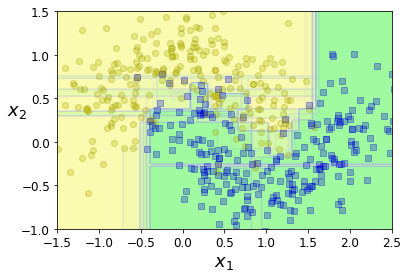

In [23]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

### 7.4.1 엑스트라 트리
- 랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용한다
- 트리를 더욱 무작위하게 만들기 위해(보통의 결정 트리처럼) 최적의 임계값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택한다
- 이와 같이 극단적으로 무작위한 트리의 랜덤 포레스트를 익스트림 랜덤트리 앙상블 (또는 줄여서 엑스트라 트리)라고 부른다
- 여기서도 편향이 늘어나지만 대신 분산을 낮추게 된다
- 엑스트라 트리를 만들려면 사이킷런의 ExtraTreesClassifier를 사용한다
- 사용법은 RandomForestClassifier와 같다
- 마찬가지로 ExtraTreesRegressor도 RandomForestRegressor와 같은 API를 제공한다

### 7.4.2 특성 중요도
- 랜덤포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것이다
- 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다

In [24]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_) :
    print(name, score)

sepal length (cm) 0.10433650940239016
sepal width (cm) 0.022632159115731364
petal length (cm) 0.4327039358678727
petal width (cm) 0.4403273956140057


- 이걸보면 가장 중요한 특성은 꽃잎의 길이(44%)와 너비(43%)이고 꽃받침의 길이와 너비는 비교적 덜 중요해 보인다(각 9%, 2%)

In [25]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [26]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [27]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

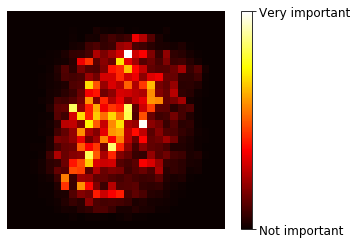

In [28]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])


plt.show()

- MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 각 픽셀의 중요도를 그래프로 나타냄

### 7.5 부스팅
- 부스팅(원래는 가설 부스팅이라 불렀습니다)
- 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법을 말한다
- 부스팅 방법에는 여러 가지가 있지만 가장 인기 있는 것은 아다부스트(AdaBoost)(Adaptive Boosting의 줄임말)와 그래디언트 부스팅이다

### 7.5.1 아다부스트
- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 높히는 것이다
- 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다
- 예를 들어 아다부스트 분류기를 만들려면 기반이 되는 첫 번째 분류기(예를들면 결정 트리)를 훈련 세트에서 훈련시키고 예측을 만든다 그 다음에 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높힌다 두번 째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다 그다음에 다시 가중치를 업데이트하는 식으로 계속된다

In [29]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators = 200,
    algorithm = "SAMME.R", learning_rate = 0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

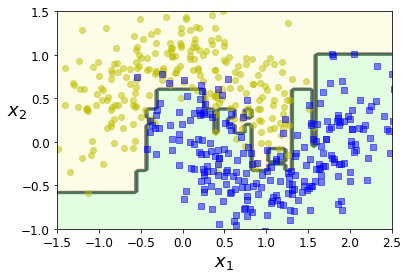

In [30]:
plot_decision_boundary(ada_clf, X, y)

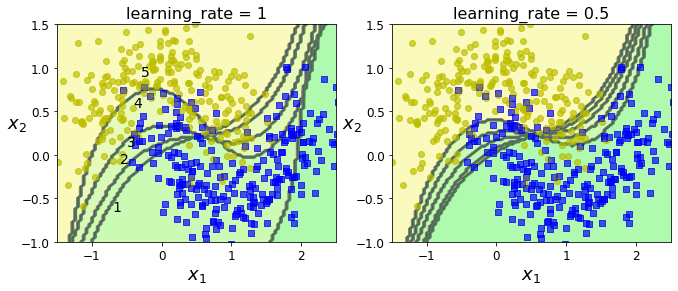

In [31]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

In [32]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

### 7.5.2 그래디언트 부스팅

- 인기가 높은 또 하나의 부스팅 알고리즘은 그래디언트 부스팅이다
- 아다부스트처럼 그래디언트 부스팅은 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가한다
- 하지만 아다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킨다


- 간단한 회귀 문제를 풀어보겠다
- 이를 그래디언트 트리 부스팅 또는 그래디언트 부스티드 회귀 트리(GBRT)라고 한다
- 먼저 DecisionTreeRegressor를 훈련 세트에 학습시켜 보자

In [33]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [34]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

- 이제 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeGegressor를 훈련시킨다

In [35]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth = 2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

- 이제 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델을 훈련시킨다

In [36]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth = 2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [37]:
X_new = np.array([[0.8]])

In [38]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [39]:
y_pred

array([0.75026781])

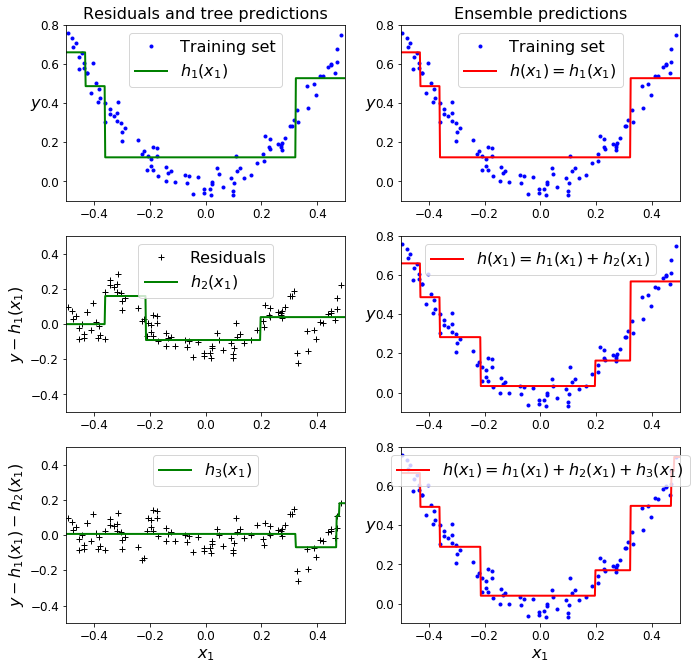

In [40]:

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

- 왼쪽 열은 이 세 트리의 예측이고 오른쪽 열은 앙상블의 예측이다
- 첫번 째 행에서는 앙상블에 트리가 하나만 있어서 첫 번째 트리의 예측과 완전히 같다
- 두 번째 행에서는 새로운 트리가 첫 번째 트리의 잔여 오차에 대해 학습되었다
- 오른쪽의 앙상블 예측이 두개의 트리 예측의 합과 같은 것을 볼 수 있다
- 비슷하게 세 번째 행에서는 또 다른 트리가 두 번째 트리의 잔여 오차에 훈련되었다
- 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 알 수 있다

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3, learning_rate = 1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

- learning rate 매개변수가 각 트리의 기여 정도를 조절한다
- 이를 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아진다
- 이는 축소(shrinkage)라고 부르는 규제 방법이다

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [43]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

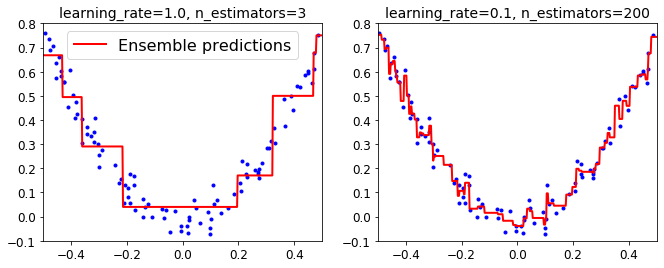

In [44]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

- 작은 학습률로 훈련 시킨 두 개의 GBRT 앙상블을 보여준다
- 왼쪽은 훈련 세트를 학습하기에는 트리가 충분하지 않은 반면
- 오른쪽은 트리가 너무 많아 훈련 세트에 과대 적합되었다

- 최적의 트리 수를 찾기 위해서는 조기 종료 기법을 사용할 수 있다
- 간단하게 구현하려면 staged_predict() 메서드를 사용한다
- 이 메서드는 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환한다
- 다음 코드는 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정한다
- 마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련시킨다

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth = 2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=84,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [46]:
min_error = np.min(errors)

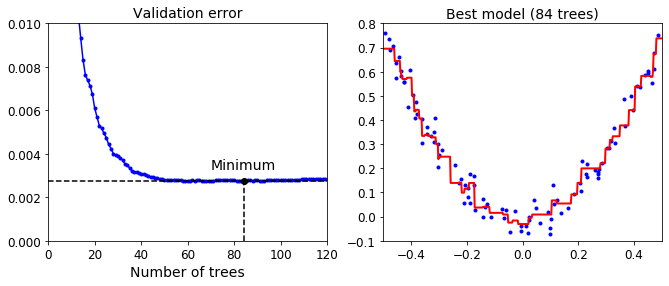

In [47]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

In [48]:
gbrt = GradientBoostingRegressor(max_depth = 2, warm_start = True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120) :
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error :
        min_val_error = val_error
        error_going_up = 0
    else :
        error_going_up += 1
        if error_going_up == 5:
            break

- GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수도 지원한다
- 예를 들어 subsample=0.25라고 하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습된다
- 편향이 높아지는 대신 분산이 낮아지고 또한 훈련 속도를 상당히 높힌다
- 이런 기법을 확률적 그래디언트 부스팅 이라고 한다(Stochastic Gradient Boosting)

### 7.6 스태킹

- 7장에서 이야기할 마지막 앙상블 모델은 스태킹(stacking)(stacked generalization의 줄임말)이다
- 이는 '앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수(직접 투표 같은)를 사용하는 대신 취합하는 모델을 훈련시킬 수 없을까'라는 기본 아이디어로 출발한다
- 

- 먼저 훈련 세트를 두 개의 서브셋으로 나눈다
- 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용한다
- 예측기들이 훈련하는 동안 이 샘플들은 전혀 보지 못했기 때문에 이때 만들어진 예측은 완전히 새로운 것이다
- 다음 첫 번째 레이어의 예측기를 사용해 두 번째 세트에 대한 예측을 만든다
- 이제 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 만들어진다
- 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있다
- 블렌더가 새 훈련 세트로 훈련이 된다
- 즉, 첫번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습된다

- 스태킹의 구현은 다음에 연습문제들을 해결할 때 해보도록 하겠다(사이킷런에서 지원안해줌)